# Climate Change Belief Analysis
#### by Classification_JS4_DSFT21

# Introduction 
Several companies are built around lessening one’s environmental impact or carbon footprint. This is because they offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.

With this context, we have created a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data. This model together will the accompanying app will help Geo-Environmental Consultation companies who are turning to social media to obtain valuable information about job applicants and to monitor the activities of their employees in relation to the values they have towards the company's projects and beliefs surrounding the ever changing global environment.

Providing an accurate and robust solution to this task will provide access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies. The app launched on **streamlit** is also an intuitive, easy to use, simple and the customer can rely on the product it.

In [1]:
import numpy as np
import pandas as pd

### Importing Libraries 

In [2]:
# visualization
import matplotlib.pyplot as plt
import warnings
import nltk
import string
import seaborn as sns

#import text classification modules
import os
from nltk.tokenize import WordPunctTokenizer
from bs4 import BeautifulSoup
from nltk.corpus import stopwords

from nltk.stem.porter import * 
from wordcloud import WordCloud
import spacy
from spacy import displacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer

# import train/test split module
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# import scoring metrice
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# suppress cell warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Load the dataset

In [7]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test_with_no_labels.csv')

In [8]:
train_df.head()

,sentiment,message,tweetid
0,1,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable",625221
1,1,It's not like we lack evidence of anthropogenic global warming,126103
2,2,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",466954


In [11]:
# Let's have a look at a sample tweet
tweet = train_df.iloc[8,1]
print(tweet)

@AceofSpadesHQ My 8yo nephew is inconsolable. He wants to die of old age like me, but will perish in the fiery hellscape of climate change.


#### Let's check the shape of the train and test sets

In [12]:
#Print out the Shape of the training data and the testing data
print('Shape of Train Dataset:',train_df.shape)
print('Shape of Test Dataset:',test_df.shape)

Shape of Train Dataset: (15819, 3)
Shape of Test Dataset: (10546, 2)


In [13]:
#Use the value_counts() method to displace the count of each sentiment in the training dataset
train_df['sentiment'].value_counts()

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

In [14]:
#Use the isnull() method to check for null values in training data
#.sum() method evaluates the total of each column of null values
train_df.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

### Now we will be cleaning the data - removing unwanted text patters, remove twitter handles, removing RT from tweets and convert to lowercase

In [15]:
#Combining both train and test data set before data cleaning as tweets in both the data set is unstructured
data = train_df.append(test_df, ignore_index=True) #Combine the two datasets and assing the variable 'data'

In [16]:
#User Defined function to clean unwanted text patterns from all tweets
# input - text to clean,pattern to replace
def remove_pattern(input_txt, pattern):
    """Removes unwanted text patterns from the tweets.
    
    Parameters
    ----------
    input_txt: string
                Original tweet string from the dataset
    
    pattern: regular expression
                pattern of text
    
    Returns
    -------
    input_txt: string
        returns the same input string without the given pattern as a result of the regular expresion on the input_text
    """
    r = re.findall(pattern, input_txt) #create an instance of the regular expression and assign the variable r
    for i in r:#Loop through the instance
        input_txt = re.sub(i, '', input_txt) #Remove the twitter handle from the dataset
        
    return input_txt

In [17]:
# remove twitter handles from the combined dataset (@user)
data['tidy_message'] = np.vectorize(remove_pattern)(data['message'], "@[\w]*")

In [18]:
#Removing RT from tweets and converting to lowercase
data['tidy_message'] = data['tidy_message'].str.replace('RT :',' ') #removing rt's
data['tidy_message'] = data['tidy_message'].apply(lambda x: x.lower())#Coverting all the tweets to lowercase since they are easier to work with

In [19]:
data.head()

,sentiment,message,tweetid,tidy_message
0,1.0,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable",625221,"polyscimajor epa chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yelvcefxkc via"
1,1.0,It's not like we lack evidence of anthropogenic global warming,126103,it's not like we lack evidence of anthropogenic global warming
2,2.0,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,698562,researchers say we have three years to act on climate change before it’s too late https://t.co/wdt0kdur2f https://t.co/z0anpt…
3,1.0,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,573736,#todayinmaker# wired : 2016 was a pivotal year in the war on climate change https://t.co/44wotxtlcd
4,1.0,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",466954,"it's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #electionnight"


In [20]:
#Initialise a Short for dictionary and assign it the variable 'short_word_dict'
short_word_dict = {
"121": "one to one",
"a/s/l": "age, sex, location",
"adn": "any day now",
"afaik": "as far as I know",
"afk": "away from keyboard",
"aight": "alright",
"alol": "actually laughing out loud",
"b4": "before",
"b4n": "bye for now",
"bak": "back at the keyboard",
"bf": "boyfriend",
"bff": "best friends forever",
"bfn": "bye for now",
"bg": "big grin",
"bta": "but then again",
"btw": "by the way",
"cid": "crying in disgrace",
"cnp": "continued in my next post",
"cp": "chat post",
"cu": "see you",
"cul": "see you later",
"cul8r": "see you later",
"cya": "bye",
"cyo": "see you online",
"dbau": "doing business as usual",
"fud": "fear, uncertainty, and doubt",
"fwiw": "for what it's worth",
"fyi": "for your information",
"g": "grin",
"g2g": "got to go",
"ga": "go ahead",
"gal": "get a life",
"gf": "girlfriend",
"gfn": "gone for now",
"gmbo": "giggling my butt off",
"gmta": "great minds think alike",
"h8": "hate",
"hagn": "have a good night",
"hdop": "help delete online predators",
"hhis": "hanging head in shame",
"iac": "in any case",
"ianal": "I am not a lawyer",
"ic": "I see",
"idk": "I don't know",
"imao": "in my arrogant opinion",
"imnsho": "in my not so humble opinion",
"imo": "in my opinion",
"iow": "in other words",
"ipn": "I’m posting naked",
"irl": "in real life",
"jk": "just kidding",
"l8r": "later",
"ld": "later, dude",
"ldr": "long distance relationship",
"llta": "lots and lots of thunderous applause",
"lmao": "laugh my ass off",
"lmirl": "let's meet in real life",
"lol": "laugh out loud",
"ltr": "longterm relationship",
"lulab": "love you like a brother",
"lulas": "love you like a sister",
"luv": "love",
"m/f": "male or female",
"m8": "mate",
"milf": "mother I would like to fuck",
"oll": "online love",
"omg": "oh my god",
"otoh": "on the other hand",
"pir": "parent in room",
"ppl": "people",
"r": "are",
"rofl": "roll on the floor laughing",
"rpg": "role playing games",
"ru": "are you",
"shid": "slaps head in disgust",
"somy": "sick of me yet",
"sot": "short of time",
"thanx": "thanks",
"thx": "thanks",
"ttyl": "talk to you later",
"u": "you",
"ur": "you are",
"uw": "you’re welcome",
"wb": "welcome back",
"wfm": "works for me",
"wibni": "wouldn't it be nice if",
"wtf": "what the fuck",
"wtg": "way to go",
"wtgp": "want to go private",
"ym": "young man",
"gr8": "great",
"8yo":"eight year old"
}

In [21]:
#Function used to lookup shortwords from the dictionary
def lookup_dict(text, dictionary):
    """Performs a lookup of the short word and returns the full meaning.
    
    Parameters
    ----------
    text: string
        Original tweet string from the dataset
    dictionary: dictionary
        dictionary with the short words as keys and the full meaning as the values
    
    Returns
    -------
    text: string
        Returns a new tweet string with the full meaning of the word as a result of replacement of the short word from the dictionary
    """
    for word in text.split(): #split the text into a list and loop through the list for find the words
        if word.lower() in dictionary: #Lower the words and see if they are in the dictionary
            if word.lower() in text.split(): #lower the words and see if they are in the text list
                text = text.replace(word, dictionary[word.lower()]) #replace the word in the text split with the values in the dictionary
    return text

In [22]:
#Perform lookup of short words and return the string with the full meaning
data['tidy_message'] = data['tidy_message'].apply(lambda x: lookup_dict(x,short_word_dict))# Use the short word 

In [23]:
#Initiatise a dictionary of apostrophe words and assign the variable 'contractions'
contractions = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [24]:
#Perform lookup of apostrophe words and return the string with the full meaning
data['tidy_message'] = data['tidy_message'].apply(lambda x: lookup_dict(x,contractions))# Use the contraction dictionary to replace the aprostophe words in data with the full meaning
data.head()

,sentiment,message,tweetid,tidy_message
0,1.0,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable",625221,"polyscimajor epa chief does not think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yelvcefxkc via"
1,1.0,It's not like we lack evidence of anthropogenic global warming,126103,it is not like we lack evidence of anthropogenic global warming
2,2.0,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,698562,researchers say we have three years to act on climate change before it’s too late https://t.co/wdt0kdur2f https://t.co/z0anpt…
3,1.0,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,573736,#todayinmaker# wired : 2016 was a pivotal year in the war on climate change https://t.co/44wotxtlcd
4,1.0,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",466954,"it is 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #electionnight"


In [25]:
# Lookup which emojis exist in the tweets and save them as a list
tweets_text = data.tidy_message.str.cat() #Concatenate the tweet string and assign the variable 'tweets_text'
emos = set(re.findall(r" ([xX:;][-']?.) ",tweets_text)) #Create a regular expression that finds the emojis in the tweets
emos_count = [] #Initialise an empty list 'emo_count'
for emo in emos: #Loop through emoji
    emos_count.append((tweets_text.count(emo), emo)) #Add emojis found into the emo_count list
sorted(emos_count,reverse=True) #Sort the list in reverse order

[(16665, ':/'),
 (1657, '; '),
 (1167, 'x '),
 (850, 'xi'),
 (294, ':…'),
 (219, 'x.'),
 (155, 'xd'),
 (59, 'x3'),
 (16, ';)'),
 (16, ':)'),
 (11, ':-'),
 (11, ':('),
 (9, ';-)'),
 (7, ':-)'),
 (6, ':a'),
 (4, '::'),
 (2, ':o'),
 (2, ':-('),
 (1, ':p')]

In [26]:
#Initialise a emoji list and assign it to emoticon_dict
emoticon_dict={
'XD':'happy',
';)':'happy',
':-)':'happy',
';-)':'happy',
':P':'happy', 
':)':'happy',
'x ':'happy',
':(':'sad',
':/':'sad'
}

In [27]:
#Lookup the emojis in the tweets and replace them with the meaning behind the tweet
data['tidy_message'] = data['tidy_message'].apply(lambda x: lookup_dict(x,emoticon_dict))# Use emoticon_dict to replace decode emojis in the dataset

In [28]:
#Function to remove the remaining emojis in the tweets
def remove_emoji(message):
    """Performs a lookup of the short word and returns the full meaning.
    
    Parameters
    ----------
    message: string
        Original tweet string from the dataset

    Returns
    -------
    emoji_pattern.sub(r'', message): string
        Returns a new tweet which has removed unnecesary emojis as a result of the regular expression 
    """
    emoji_pattern = re.compile("["                   # Create a regular expression
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', message)

In [29]:
#Perform lookup of emojis on the dataset and replace the tweet
data['tidy_message'] = data['tidy_message'].apply(lambda x: remove_emoji(x))#Use the remove_emoji function to replace tweets in the dataset

In [30]:
# remove special characters, numbers, punctuations
data['tidy_message'] = data['tidy_message'].str.replace("[^a-zA-Z#]", " ")
data.head(10)

,sentiment,message,tweetid,tidy_message
0,1.0,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable",625221,polyscimajor epa chief does not think carbon dioxide is main cause of global warming and wait what https t co yelvcefxkc via
1,1.0,It's not like we lack evidence of anthropogenic global warming,126103,it is not like we lack evidence of anthropogenic global warming
2,2.0,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,698562,researchers say we have three years to act on climate change before it s too late https t co wdt kdur f https t co z anpt
3,1.0,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,573736,#todayinmaker# wired was a pivotal year in the war on climate change https t co wotxtlcd
4,1.0,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",466954,it is and a racist sexist climate change denying bigot is leading in the polls #electionnight
5,1.0,Worth a read whether you do or don't believe in climate change https://t.co/ggLZVNYjun https://t.co/7AFE2mAH8j,425577,worth a read whether you do or do not believe in climate change https t co gglzvnyjun https t co afe mah j
6,1.0,RT @thenation: Mike Pence doesn’t believe in global warming or that smoking causes lung cancer. https://t.co/gvWYaauU8R,294933,mike pence doesn t believe in global warming or that smoking causes lung cancer https t co gvwyaauu r
7,1.0,"RT @makeandmendlife: Six big things we can ALL do today to fight climate change, or how to be a climate activistÃ¢â‚¬Â¦ https://t.co/TYMLu6DbNM hÃ¢â‚¬Â¦",992717,six big things we can all do today to fight climate change or how to be a climate activist https t co tymlu dbnm h
8,1.0,"@AceofSpadesHQ My 8yo nephew is inconsolable. He wants to die of old age like me, but will perish in the fiery hellscape of climate change.",664510,my eight year old nephew is inconsolable he wants to die of old age like me but will perish in the fiery hellscape of climate change
9,1.0,RT @paigetweedy: no offense… but like… how do you just not believe… in global warming………,260471,no offense but like how do you just not believe in global warming


#### Removing shorter words less than 3 letter because it will not have any bearing on our dataset

In [31]:
#remove short words of less than 3 letters in length
data['tidy_message'] = data['tidy_message'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))#Remove words that are shorter than 3 characters

In [32]:
data.head()

,sentiment,message,tweetid,tidy_message
0,1.0,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable",625221,polyscimajor chief does think carbon dioxide main cause global warming wait what https yelvcefxkc
1,1.0,It's not like we lack evidence of anthropogenic global warming,126103,like lack evidence anthropogenic global warming
2,2.0,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,698562,researchers have three years climate change before late https kdur https anpt
3,1.0,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,573736,#todayinmaker# wired pivotal year climate change https wotxtlcd
4,1.0,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",466954,racist sexist climate change denying bigot leading polls #electionnight


In [33]:
#Use tokenization to the words into a list of tokens 
tokenized_tweet = data['tidy_message'].apply(lambda x: x.split()) #Tokenize the dataset
tokenized_tweet.head()

0    [polyscimajor, chief, does, think, carbon, dioxide, main, cause, global, warming, wait, what, https, yelvcefxkc]
1                                                              [like, lack, evidence, anthropogenic, global, warming]
2                          [researchers, have, three, years, climate, change, before, late, https, kdur, https, anpt]
3                                            [#todayinmaker#, wired, pivotal, year, climate, change, https, wotxtlcd]
4                                   [racist, sexist, climate, change, denying, bigot, leading, polls, #electionnight]
Name: tidy_message, dtype: object

In [34]:
#Use PorterStemmer() to strip suffixes from the words
from nltk.stem.porter import * #Import * from nltk.stem.porter
stemmer = PorterStemmer() #Initialize an instance of PorterStemmer and assign it a variable 'stemmer'

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) #Stem the dataset
tokenized_tweet.head()

0    [polyscimajor, chief, doe, think, carbon, dioxid, main, caus, global, warm, wait, what, http, yelvcefxkc]
1                                                                [like, lack, evid, anthropogen, global, warm]
2                            [research, have, three, year, climat, chang, befor, late, http, kdur, http, anpt]
3                                           [#todayinmaker#, wire, pivot, year, climat, chang, http, wotxtlcd]
4                                     [racist, sexist, climat, chang, deni, bigot, lead, poll, #electionnight]
Name: tidy_message, dtype: object

In [35]:
#We will now bring the tokens back together
for i in range(len(tokenized_tweet)): #Lopp through token list of stems
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i]) #Join the list into a string of characters

data['tidy_message'] = tokenized_tweet #Assign the string of words to the dataset in the tid_message column

In [36]:
#Split the dataset back to the training set and the testing set
train = data[:len(train_df)] #Split to the lenght of original training set
test = data[len(train_df):]  #Split to the length of original testing set

In [37]:
#Use the .shape to see the length of the train dataset with the amound of features
train.shape

(15819, 4)

In [38]:
#Use the value_counts to see the values of the individual classes
train['sentiment'].value_counts() 

 1.0    8530
 2.0    3640
 0.0    2353
-1.0    1296
Name: sentiment, dtype: int64

### Exploratory Data Analysis 

We perform thorough analysis of our data to see if we can gain any meaningful insights. The EDA is a fundemental stage and we need more we work on our text data. We have data being generated from tweets, digital media platforms, blogs, and a whole host of other sources. As a data scientists, our main goal is to analyze data to help organizations make data-driven decisions.

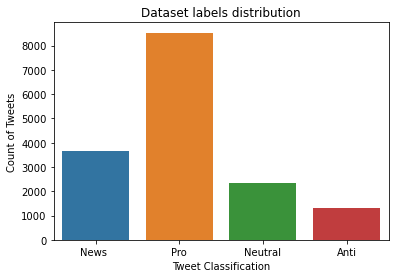

No of Tweets labelled as News: 3640
No of Tweets labelled as Pro: 8530
No of Tweets labelled as Neutral: 2353
No of Tweets labelled as Anti: 1296
Data is unbalanced and may need to be resampled in order to balance it with only 23.01 % news tweets, 53.92 % (pro)positive tweets, 14.87 % neutral tweets and 8.19 % (anti)negative tweets


In [39]:
#Create a barplot for the train dataset classes
News = train['sentiment'].value_counts()[2] #Take values of class 2 and assign the variable 'News'
Pro= train['sentiment'].value_counts()[1]   #Take values of class 1 and assign the variabe 'Pro'
Neutral=train['sentiment'].value_counts()[0]#Take the values of class 0 and assign the variable 'Neutral'
Anti=train['sentiment'].value_counts()[-1]  #Take the values of class -1 and assing the variable 'Anti'

sns.barplot(['News ','Pro','Neutral','Anti'],[News,Pro,Neutral,Anti]) #Use seaborn barplot and add a list of classes
plt.xlabel('Tweet Classification') #X-label of the data
plt.ylabel('Count of Tweets')      #Y_label of the data
plt.title('Dataset labels distribution') #Give the data a title 'Dataset lables distribution'
plt.show() #Display the dataset

print('No of Tweets labelled as News:',News) #Print out all the classes values
print('No of Tweets labelled as Pro:',Pro)
print('No of Tweets labelled as Neutral:',Neutral)
print('No of Tweets labelled as Anti:',Anti)

print('Data is unbalanced and may need to be resampled in order to balance it with only',round(((News/(News+Pro+Neutral+Anti))*100),2),'% news tweets,',
      round(((Pro/(Pro+News+Neutral+Anti))*100),2),'% (pro)positive tweets,',round(((Neutral/(Neutral+Pro+News+Anti))*100),2),'% neutral tweets and',
      round(((Anti/(Anti+Neutral+News+Pro))*100),2),'% (anti)negative tweets') #Print out the percentages that each class represents in the dataset

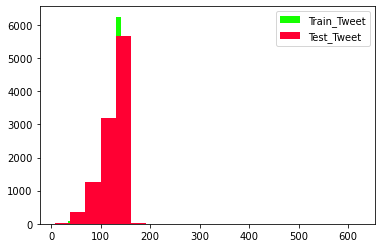

In [40]:
#Check the Distribution of Length of Tweets in train and Test Dataset
tweetLengthTrain = train['message'].str.len() #Compute the length of the elements in the training set
tweetLengthTest = test['message'].str.len()   #Compute the length of the elements in the test set
flatui = ["#15ff00", "#ff0033"]#Color scheme
sns.set_palette(flatui)
plt.hist(tweetLengthTrain,bins=20,label='Train_Tweet') #Plot the histogram of training set
plt.hist(tweetLengthTest,bins=20,label='Test_Tweet')   #Plot the histogram of the test set
plt.legend()
plt.show()

In [41]:
#create a new length value column that contains the lengths of the messages
train['message_length'] = train['message'].apply(len)

Text(0.5, 0, 'Sentiment Class')

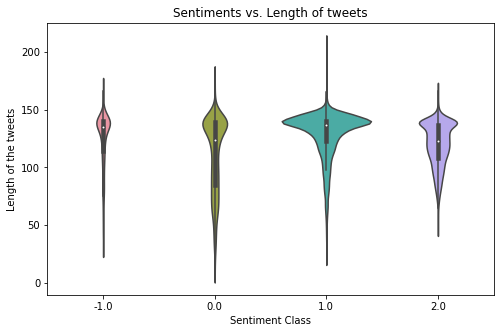

In [42]:
#Create a violinplot of the dataset
plt.figure(figsize=(8,5)) #Set the figsize to 8 and 5 respectively
plt.title('Sentiments vs. Length of tweets') #Add the title of the violin plot
sns.violinplot(x='sentiment', y='message_length', data=train,scale='count') #Add the dimentions of the violin plot
plt.ylabel("Length of the tweets") #Y_lable of the plot
plt.xlabel("Sentiment Class") #X_label of the plot

<AxesSubplot:xlabel='sentiment', ylabel='message_length'>

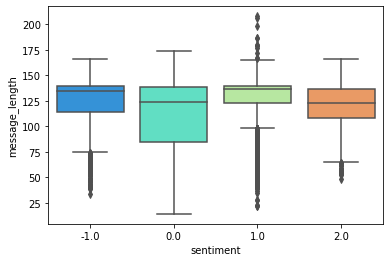

In [43]:
#Use seaborn to create a boxplot using the message length and the sentiment
sns.boxplot(x='sentiment',y='message_length',data=train,palette='rainbow')

In [44]:
#Use groupby in order to numerically display what the boxplot is trying to show to the user
train['message_length'].groupby(train['sentiment']).describe()

,count,mean,std,min,25%,50%,75%,max
sentiment,,,,,,,,
-1.0,1296.0,123.725309,24.293352,34.0,114.0,135.0,140.0,166.0
0.0,2353.0,110.925202,32.362798,14.0,85.0,124.0,139.0,174.0
1.0,8530.0,128.970692,19.956673,22.0,123.0,137.0,140.0,208.0
2.0,3640.0,119.919780,19.002282,48.0,108.0,123.0,137.0,166.0


In [45]:
#Create strings for each class
positive_words =' '.join([text for text in data['tidy_message'][data['sentiment'] == 1]]) #Words in the positve class
negative_words = ' '.join([text for text in data['tidy_message'][data['sentiment'] == -1]]) #Words in negative class
normal_words =' '.join([text for text in data['tidy_message'][data['sentiment'] == 0]]) #Words in the neutral class
news_words =' '.join([text for text in data['tidy_message'][data['sentiment'] == 2]]) #Words in the news class

In [46]:
#Create a user defined function to display a word cloud for each class
def word_cloud(class_words):
    """Generates a word cloud visualization of words in the different class.
    
    Parameters
    ----------
    class_words: string
        Words in each class

    Returns
    -------
    plt.show(): wordcloud visualisation
        Returns a visualisation of all the words that come from the class_words string
    """
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(class_words)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title("Most Common positive words")
    plt.axis('off')
    return plt.show()

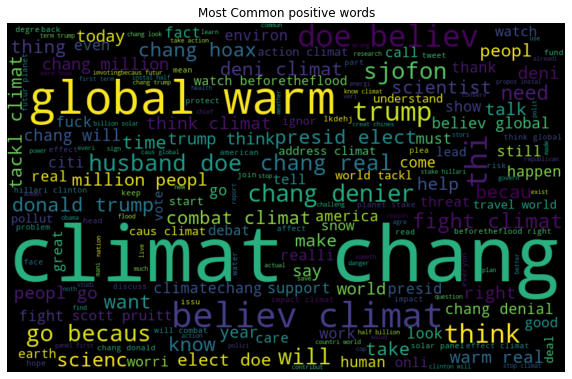

In [47]:
#Visualise all words from the positive class
word_cloud(positive_words)

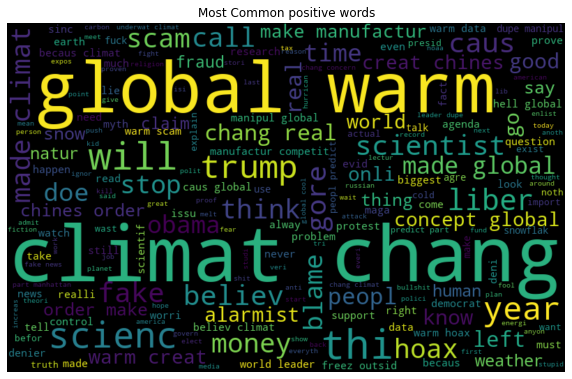

In [48]:
#Visualise all words from the negative class class
word_cloud(negative_words)

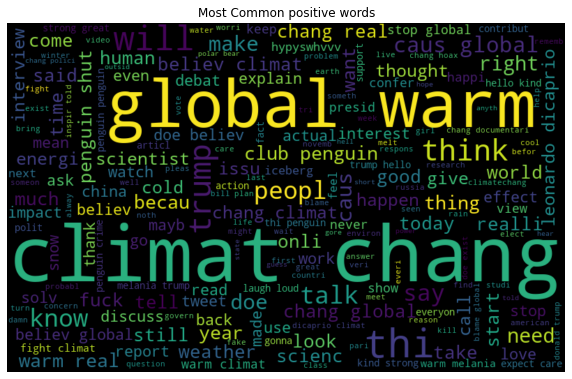

In [49]:
#Visualise all words from the neutral class
word_cloud(normal_words)

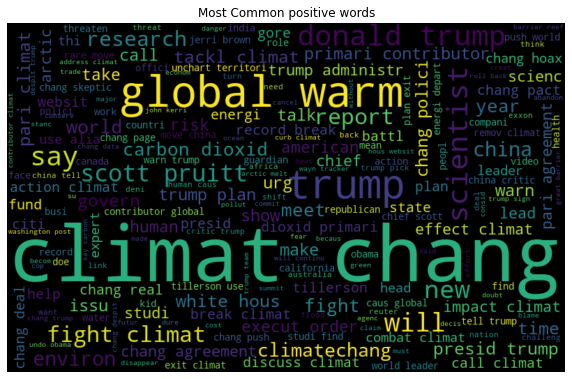

In [50]:
#Visualise all words from the news class
word_cloud(news_words)

In [51]:
#Create a function to collect hashtags
def hashtag_extract(x):
    """Generate a list of all the hastags in different tweets.
    
    Parameters
    ----------
    x: string
        Original tweet from the training dataset

    Returns
    -------
    hashtags : list
        Returns a list of all hashtags in x
    """
    hashtags = [] #Initialize an empty list
    for i in x:   #Loop over the words in the tweet
        ht = re.findall(r"#(\w+)", i) #Create a regular expression to get the hashtags in a tweet
        hashtags.append(ht) #Add all those hashtags to the empty hashtag list

    return hashtags

In [52]:
# extracting hashtags from the news
HT_news = hashtag_extract(data['tidy_message'][data['sentiment'] == 2])
# extracting hashtags from positive sentiments
HT_positive = hashtag_extract(data['tidy_message'][data['sentiment'] == 1])
# extract hashtags from neutral sentiments
HT_normal = hashtag_extract(data['tidy_message'][data['sentiment'] == 0])
# extracting hashtags from negative sentiments
HT_negative = hashtag_extract(data['tidy_message'][data['sentiment'] == -1])

# unnesting list of all sentiments
HT_news = sum(HT_news,[])
HT_positive = sum(HT_positive,[])
HT_normal = sum(HT_normal,[])
HT_negative = sum(HT_negative,[])

In [53]:
#Create a function that visualises the barplot distribution of the hashtags
def bar_dist(x):
    """Generate a barplot of the top appearing hashtags in a class.
    
    Parameters
    ----------
    x: list
        List of all hashtag values in a class without the #

    Returns
    -------
    plt.show() : matplotlib barplot
        Returns a barplot of x
    """
    a = nltk.FreqDist(x) #Create a count of the hashtags in the list
    d = pd.DataFrame({'Hashtag': list(a.keys()), #Create a dataframe with the values of the counts of a
                  'Count': list(a.values())})  
    d = d.nlargest(columns="Count", n = 10) # selecting top 10 most frequent hashtags  
    plt.figure(figsize=(16,5))
    ax = sns.barplot(data=d, x= "Hashtag", y = "Count") #Initisalise seaborn barplot
    ax.set(ylabel = 'Count') #Set lables
    return plt.show()

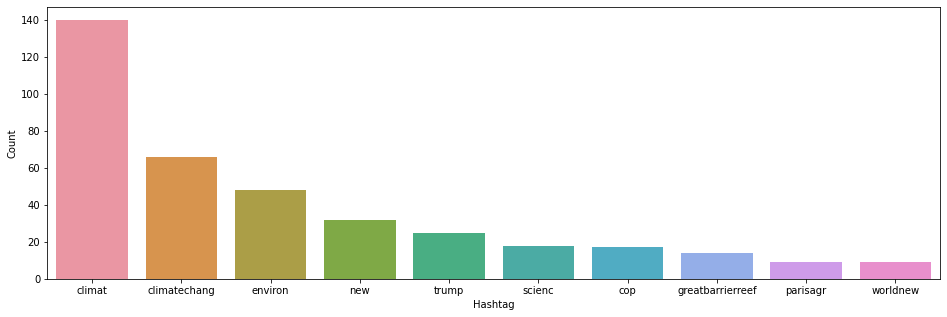

In [54]:
#Display barplot of the News hastags
bar_dist(HT_news)

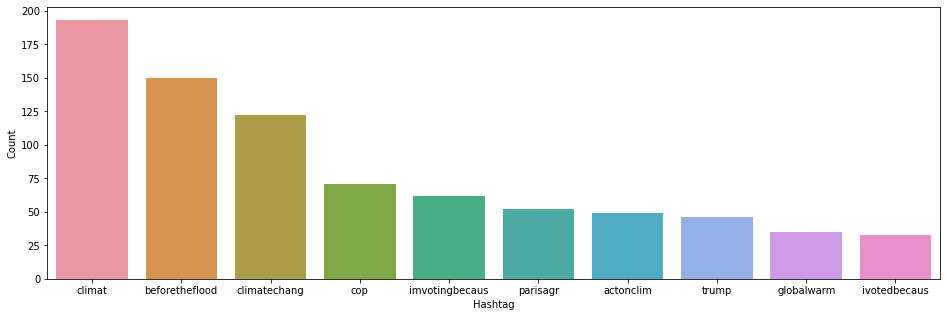

In [55]:
#Display barplot of the positive hastags
bar_dist(HT_positive)

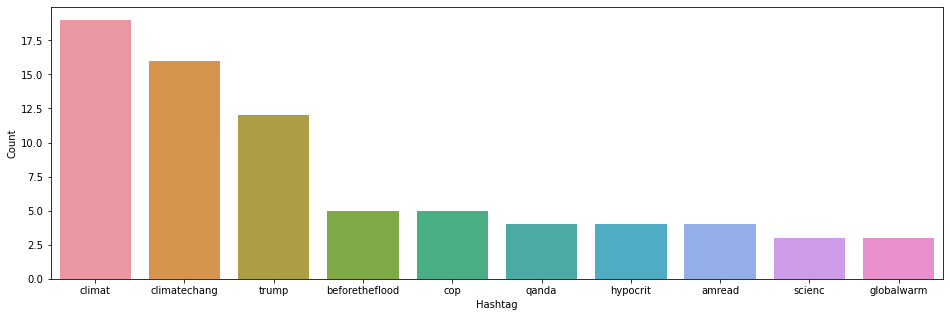

In [56]:
#Display barplot of the neutral hastags
bar_dist(HT_normal)

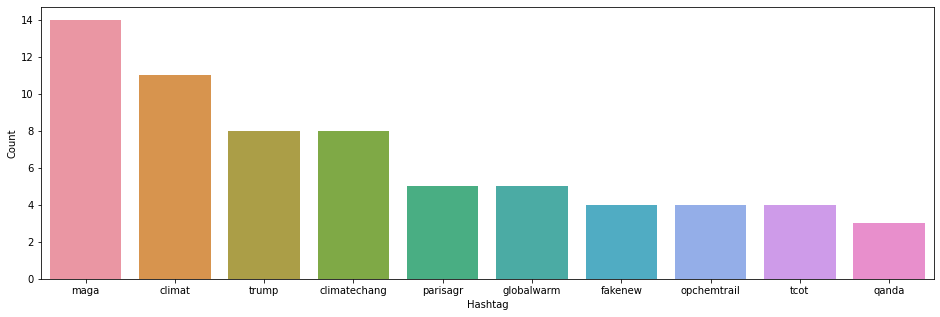

In [57]:
#Display barplot of the neutral hastags
bar_dist(HT_negative)

# Feature Engineering and Selection

In [58]:
#Splitting features and target variables

X = train['tidy_message'] #X is the features of the cleaned tweets
y = train['sentiment']    #Y is the target variable which is the train sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42) #Splitting train set into training and testing data
#Print out the shape of the training set and the testing set
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(12655,)
(3164,)
(12655,)
(3164,)


In [59]:
# import and call the TFidfVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer #Import TFidfVectorizer from sklearn
tfidf = TfidfVectorizer() #Call the TFidfVectorizer and assign it to the tfidf variable

In [60]:
#import CountVectorizer and call it
from sklearn.feature_extraction.text import CountVectorizer #Import CountVectorizer from sklearn

cf= CountVectorizer() #Call the CountVectorizer and assing it to the variable 'cf'

In [61]:
#Import metrics from sklearn
from sklearn import metrics

In [62]:
# create a pipeline and fit it with a Logistic Regression
from sklearn.linear_model import LogisticRegression #Import Logistic Regression from sklearn

model = LogisticRegression(multi_class='ovr') #Call the Logistic Regression model and assign it to the variable 'model'

clf = Pipeline([('tfidf', tfidf), ('clf', model)]) #Create a pipeline with the TF-IDF Vectorizer with the logistic model


clf.fit(X_train, y_train) #Fit the training data to the pipeline

y_pred= clf.predict(X_test) #Make predictions and assign the predictions to y_pred

print('accuracy %s' % accuracy_score(y_pred, y_test)) #Print the accuracy
print('f1_score %s' % metrics.f1_score(y_test,y_pred,average='weighted')) #Print the weighted f1 score
print(classification_report(y_test, y_pred)) #Classification

accuracy 0.7269279393173198
f1_score 0.703344752195809
              precision    recall  f1-score   support

        -1.0       0.86      0.26      0.40       278
         0.0       0.64      0.33      0.44       425
         1.0       0.73      0.88      0.80      1755
         2.0       0.72      0.77      0.74       706

    accuracy                           0.73      3164
   macro avg       0.74      0.56      0.59      3164
weighted avg       0.73      0.73      0.70      3164



In [63]:
# create a pipeline and fit it with a Logistic Regression
from sklearn.linear_model import LogisticRegression #Import logistic regression model from sklearn

model = LogisticRegression(C=100,multi_class='ovr') #Call logistic regression model and assign variable 'model'

clf_sam1 = Pipeline([('cf', cf), ('clf', model)]) #Create a pipeline with the logistic model and bag-of-words


clf_sam1.fit(X_train, y_train) #Fit the training set

y_pred= clf_sam1.predict(X_test) #Fit the test set

print('accuracy %s' % accuracy_score(y_pred, y_test)) #Print accuracy
print('f1_score %s' % metrics.f1_score(y_test,y_pred,average='weighted')) #Print f1 score
print(classification_report(y_test, y_pred)) #Print classification report

accuracy 0.6905815423514539
f1_score 0.6889004246265822
              precision    recall  f1-score   support

        -1.0       0.54      0.43      0.48       278
         0.0       0.44      0.45      0.45       425
         1.0       0.77      0.77      0.77      1755
         2.0       0.70      0.74      0.72       706

    accuracy                           0.69      3164
   macro avg       0.61      0.60      0.60      3164
weighted avg       0.69      0.69      0.69      3164



In [64]:
## create a pipeline and fit it with a Linear Support Vector Classifier
from sklearn.svm import LinearSVC #Import LinearSVC from sklearn 

classifier = LinearSVC() #Call LinearSVC and assign the variable 'classifier'

clf = Pipeline([('tfidf', tfidf), ('clf', classifier)]) #Create a pipeline with the tdidf

clf.fit(X_train, y_train) #Fit the model
y_pred = clf.predict(X_test) #Make predictions and assign the variable 'y_pred'

print('accuracy %s' % accuracy_score(y_pred, y_test)) #Print the accuracy
print('f1_score %s' % metrics.f1_score(y_test,y_pred,average='weighted')) #Print the f1-score
print(classification_report(y_test, y_pred)) #Print the classification report

accuracy 0.7262958280657396
f1_score 0.7175008660647714
              precision    recall  f1-score   support

        -1.0       0.66      0.42      0.52       278
         0.0       0.51      0.41      0.46       425
         1.0       0.77      0.83      0.80      1755
         2.0       0.73      0.78      0.76       706

    accuracy                           0.73      3164
   macro avg       0.67      0.61      0.63      3164
weighted avg       0.72      0.73      0.72      3164



In [65]:
#Create a pipeline and make predictions of the bag of words using linearSVC
from sklearn.svm import LinearSVC #Import LinearSVC from the sklearn


clf= Pipeline([('cf', cf),('clf',  LinearSVC())]) #Create a pipeline with the bag or words features and the linearSVC

clf.fit(X_train, y_train) #Fit the training data to the pipeline

y_pred = clf.predict(X_test) #Make predictions with the test data

print('accuracy %s' % accuracy_score(y_pred, y_test)) #Print out the accuracy
print('f1_score %s' % metrics.f1_score(y_test,y_pred,average='weighted')) #Print out the f1 score
print(classification_report(y_test, y_pred)) #Print out the classification report

accuracy 0.7019595448798989
f1_score 0.6999714600987033
              precision    recall  f1-score   support

        -1.0       0.54      0.43      0.48       278
         0.0       0.46      0.47      0.46       425
         1.0       0.77      0.78      0.78      1755
         2.0       0.72      0.74      0.73       706

    accuracy                           0.70      3164
   macro avg       0.62      0.61      0.61      3164
weighted avg       0.70      0.70      0.70      3164



In [66]:
## create a pipeline and fit it with a  Support Vector Classifier
from sklearn.svm import SVC #Import SVC from sklearn 

classifier = SVC(kernel='rbf') #Call the SVC with the kernel='rbf' parameter

clf_rbf = Pipeline([('tfidf', tfidf), ('clf', classifier)]) #Add the SVC model to the pipeline

clf_rbf.fit(X_train, y_train) #Fit the training data
y_pred = clf_rbf.predict(X_test) #Make predictions to the test set and assign the variable 'y_pred'

print('accuracy %s' % accuracy_score(y_pred, y_test)) #Print the accuracy
print('f1_score %s' % metrics.f1_score(y_test,y_pred,average='weighted')) #Print the f1 score
print(classification_report(y_test, y_pred)) #Print out the classification

accuracy 0.7411504424778761
f1_score 0.7154055370512766
              precision    recall  f1-score   support

        -1.0       0.87      0.30      0.45       278
         0.0       0.72      0.30      0.42       425
         1.0       0.73      0.90      0.81      1755
         2.0       0.76      0.78      0.77       706

    accuracy                           0.74      3164
   macro avg       0.77      0.57      0.61      3164
weighted avg       0.75      0.74      0.72      3164



In [67]:
## create a pipeline and fit it with a  Support Vector Classifier
from sklearn.svm import SVC #Import SVC from sklearn 

classifier = SVC(kernel='rbf') #Call the SVC with the kernel='rbf' parameter

clf_rbfc = Pipeline([('cf', cf), ('clf', classifier)]) #Add the SVC model to the pipeline

clf_rbfc.fit(X_train, y_train) #Fit the training data
y_pred = clf_rbfc.predict(X_test) #Make predictions to the test set and assign the variable 'y_pred'

print('accuracy %s' % accuracy_score(y_pred, y_test)) #Print the accuracy
print('f1_score %s' % metrics.f1_score(y_test,y_pred,average='weighted')) #Print the f1 score
print(classification_report(y_test, y_pred)) #Print out the classification

accuracy 0.7259797724399494
f1_score 0.699100892115463
              precision    recall  f1-score   support

        -1.0       0.86      0.22      0.35       278
         0.0       0.64      0.32      0.43       425
         1.0       0.73      0.89      0.80      1755
         2.0       0.73      0.77      0.75       706

    accuracy                           0.73      3164
   macro avg       0.74      0.55      0.58      3164
weighted avg       0.73      0.73      0.70      3164



In [69]:
test_x = test['message'] #Take test messages and assign variable test_x

In [70]:
y_pred = clf_rbf.predict(test_x) #Make rbf predictions and assign to t_pred

In [71]:
test['sentiment'] = y_pred #Add preditions to test data by create a new column 'sentiment'

In [72]:
test['sentiment'] = test['sentiment'].astype(int) #Change the datatype of the submission

In [73]:
test[['tweetid', 'sentiment']].to_csv('model_final.csv', index=False)#Extract twitter ID as sentiments to submit to kaggle